In [33]:
import os
import glob
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pyarrow.parquet as pq


In [ ]:
#  Load Multiple Months of NYC TLC Data
data_dir = "data/taxi/"
months = ["2017-01", "2017-02"]  # Add more as needed
all_dfs = []
columns = [
    'tpep_pickup_datetime', 'tpep_dropoff_datetime',
    'PULocationID', 'DOLocationID',
    'passenger_count', 'trip_distance', 'payment_type',
    'fare_amount', 'tip_amount', 'RatecodeID', 'congestion_surcharge'
]
for month in months:
    for color in ["yellow"]:
        file_path = os.path.join(data_dir, f"{color}_tripdata_{month}.parquet")
        if os.path.exists(file_path):
            df = pd.read_parquet(file_path)
            df['pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
            df['dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
            df['pickup_hour'] = df['pickup_datetime'].dt.hour
            df['pickup_day'] = df['pickup_datetime'].dt.dayofweek
            df['pickup_zone'] = df['PULocationID']
            df['dropoff_zone'] = df['DOLocationID']
            all_dfs.append(df)

# Combine
trips_df = pd.concat(all_dfs, ignore_index=True)
print("Combined shape:", trips_df.shape)

Combined shape: (18880595, 25)


In [ ]:
# Aggregate Demand and more features by hour and zone
grouped = trips_df.groupby(['dropoff_zone', pd.Grouper(key='dropoff_datetime', freq='1H')])
agg = grouped.agg(
    dropoff_count=('dropoff_zone', 'size'),
    avg_fare_amount=('fare_amount', 'mean'),
    avg_trip_distance=('trip_distance', 'mean'),
    avg_passenger_count=('passenger_count', 'mean'),
    avg_congestion_surcharge=('congestion_surcharge', 'mean')
).reset_index()

/var/folders/_q/59t7jnzs2_3flb50g60jzgsh0000gp/T/ipykernel_80963/2059901776.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  grouped = trips_df.groupby(['dropoff_zone', pd.Grouper(key='dropoff_datetime', freq='1H')])


In [18]:
# Pivot for multivariate time series
agg_pivoted = agg.pivot(index='dropoff_datetime', columns='dropoff_zone')
agg_pivoted = agg_pivoted.fillna(0)

# Flatten multi-index columns
agg_pivoted.columns = ['{}_{}'.format(metric, zone) for metric, zone in agg_pivoted.columns]

# Standardize features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(agg_pivoted.values)
X_full = torch.tensor(scaled_data[:-1], dtype=torch.float)
y = torch.tensor(scaled_data[1:], dtype=torch.float)

/var/folders/_q/59t7jnzs2_3flb50g60jzgsh0000gp/T/ipykernel_80963/2385219872.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  agg_pivoted = agg_pivoted.fillna(0)


In [ ]:
# Extract zone ids and edge index from co-visitation
zone_ids = sorted(set(trips_df['dropoff_zone'].unique()))
zone_to_idx = {z: i for i, z in enumerate(zone_ids)}

# Build co-visitation edges/graph
zone_transitions = trips_df.groupby(['pickup_zone', 'dropoff_zone']).size().reset_index(name='weight')
zone_transitions = zone_transitions[zone_transitions['pickup_zone'].isin(zone_ids) & zone_transitions['dropoff_zone'].isin(zone_ids)]
edge_index = torch.tensor(zone_transitions[['pickup_zone', 'dropoff_zone']].replace(zone_to_idx).values.T, dtype=torch.long)


In [ ]:
# Print top co-visitation pairs (pickup -- dropoff) by trip frequency
print(zone_transitions.sort_values(by='weight', ascending=False).head(10))

       pickup_zone  dropoff_zone  weight
29274          264           264  268767
25757          237           236  105714
25511          236           236   93309
25512          236           237   89154
25758          237           237   79189
26222          239           238   54486
26136          239           142   51684
14739          142           239   47212
25987          238           239   46083
7654            79            79   44648


In [ ]:
# GNN + RNN Model
class GNNRNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=None):
        super().__init__()
        self.gcn = GCNConv(input_dim, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim or input_dim)

    def forward(self, x, edge_index):
        x = self.gcn(x, edge_index)
        x = x.unsqueeze(0)  # [1, seq_len, features]
        out, _ = self.rnn(x)
        return self.fc(out.squeeze(0))

In [ ]:
# Train Model
model = GNNRNNModel(input_dim=X_full.shape[1])
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
for epoch in range(60):
    model.train()
    optimizer.zero_grad()
    out = model(X_full, edge_index)
    loss = loss_fn(out, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.8386
Epoch 10, Loss: 0.7700
Epoch 20, Loss: 0.7099
Epoch 30, Loss: 0.6717
Epoch 40, Loss: 0.6492


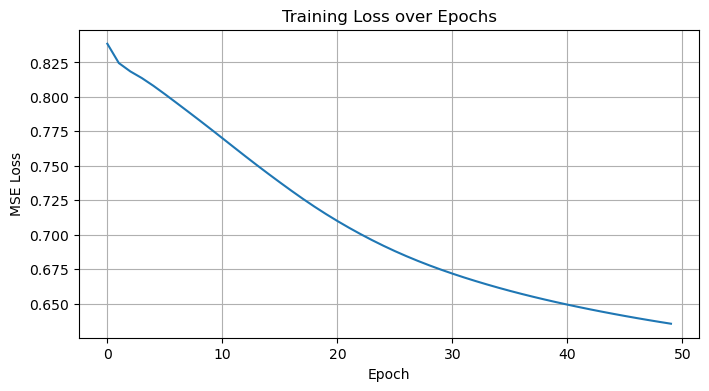

In [ ]:
# Visualize Loss
plt.figure(figsize=(8,4))
plt.plot(losses)
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()


In [ ]:
# Per-Zone RMSE
y_true = y.detach().numpy()
y_pred = out.detach().numpy()
zone_errors = {}
for i in range(y.shape[1]):
    rmse = mean_squared_error(y_true[:, i], y_pred[:, i], squared=False)
    zone_errors[f"Zone_{i}"] = rmse

sorted_errors = sorted(zone_errors.items(), key=lambda x: -x[1])
print("Top 5 hardest-to-predict zones by RMSE:")
for zone, err in sorted_errors[:5]:
    print(f"{zone}: {err:.2f}")


Top 5 hardest-to-predict zones by RMSE:
Zone_501: 1.01
Zone_107: 1.00
Zone_369: 1.00
Zone_631: 1.00
Zone_893: 1.00


/Users/julia/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/julia/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/julia/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/julia/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate t

In [ ]:
# Multi-Step Forecasting (for now 3 steps)
model.eval()
horizon = 3
input_seq = X_full.clone()
predictions = []
for step in range(horizon):
    output = model(input_seq, edge_index)
    predictions.append(output[-1].unsqueeze(0))
    input_seq = torch.cat([input_seq[1:], output[-1].unsqueeze(0)])

multi_step_preds = torch.cat(predictions)
print("Multi-step forecast shape:", multi_step_preds.shape)

Multi-step forecast shape: torch.Size([3, 1310])


/Users/julia/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


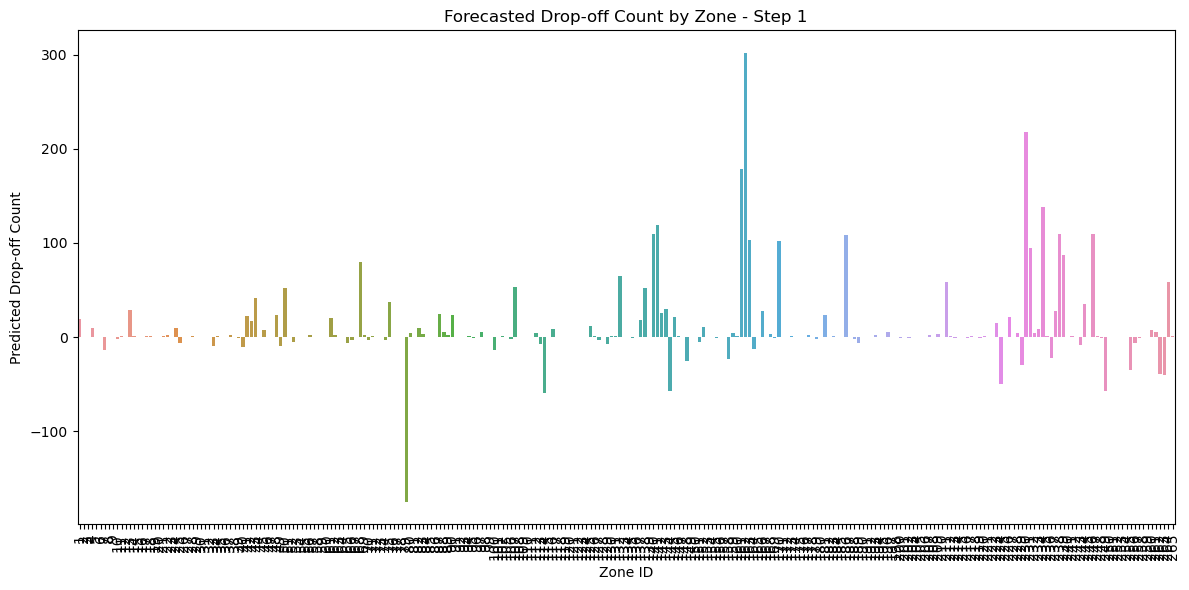

/Users/julia/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


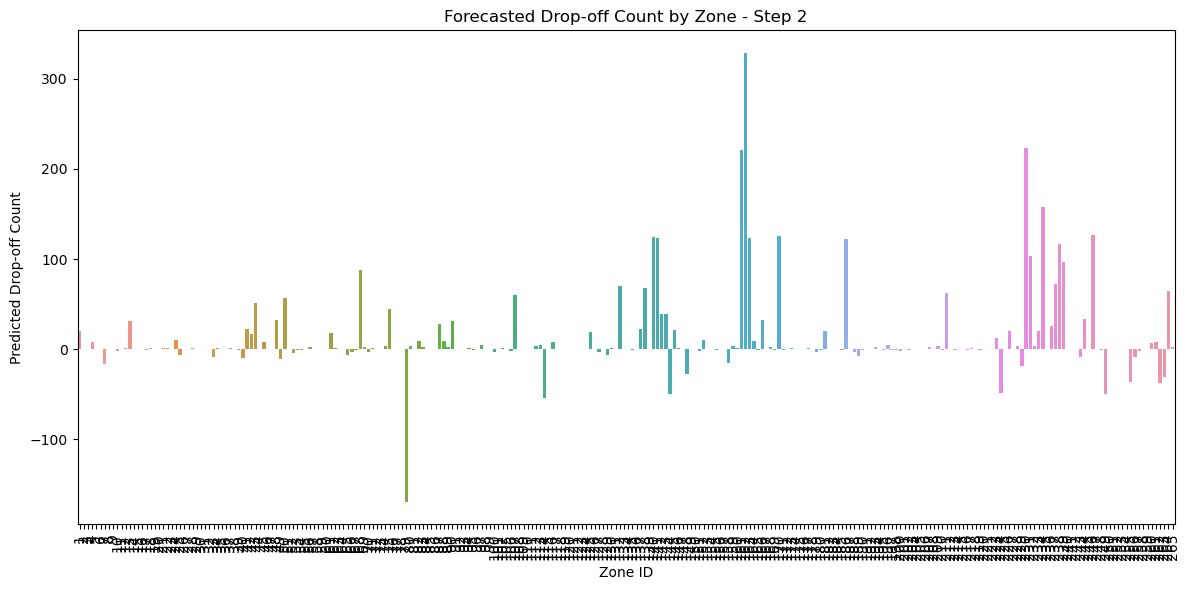

/Users/julia/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


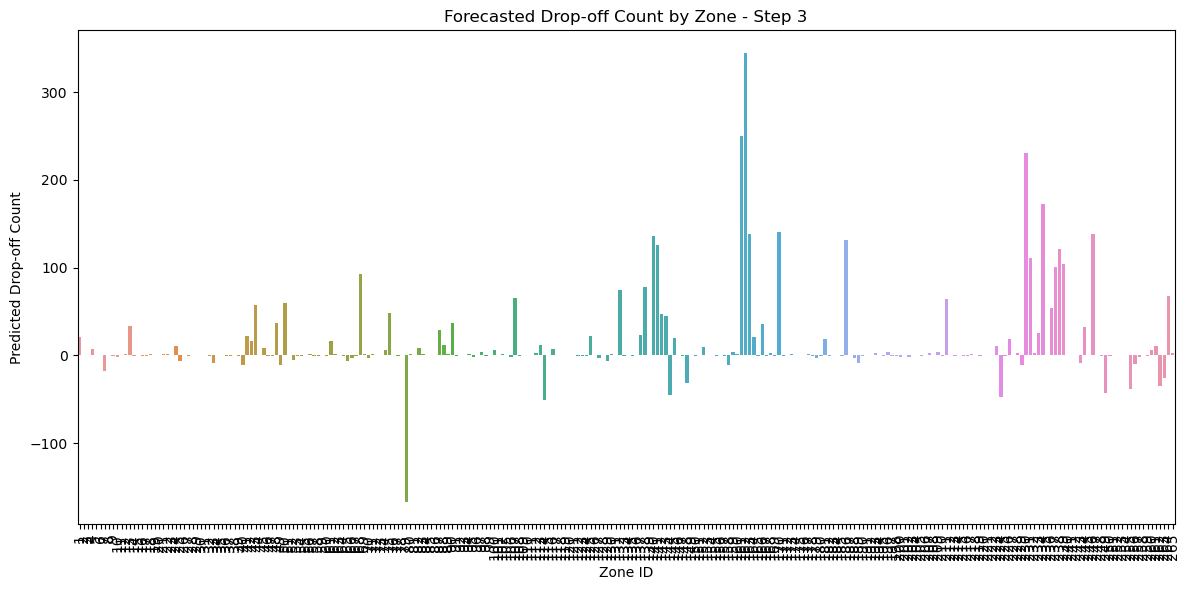

In [ ]:
# Visualize Forecasted Zone Crowd Density Over Time
multi_step_real = scaler.inverse_transform(multi_step_preds.detach().numpy()) # reverse normalization
feature_names = agg_pivoted.columns
zone_features = [name for name in feature_names if name.startswith("dropoff_count_")]
zone_indices = [feature_names.get_loc(name) for name in zone_features]

for step in range(horizon):
    values = multi_step_real[step, zone_indices]
    zone_ids_extracted = [int(name.split('_')[-1]) for name in zone_features]
    plt.figure(figsize=(12, 6))
    sns.barplot(x=zone_ids_extracted, y=values)
    plt.title(f"Forecasted Drop-off Count by Zone - Step {step + 1}")
    plt.xlabel("Zone ID")
    plt.ylabel("Predicted Drop-off Count")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

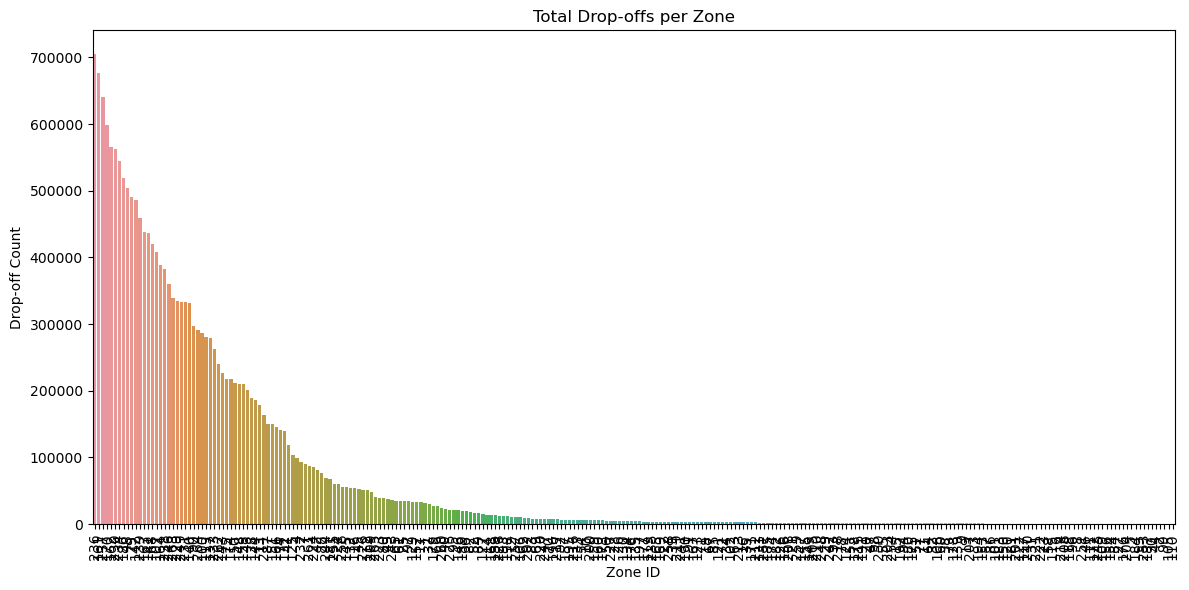

In [ ]:
# Visualize Zone Crowd Density
import seaborn as sns
zone_total = trips_df.groupby('dropoff_zone').size().sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=zone_total.index.astype(str), y=zone_total.values)
plt.title("Total Drop-offs per Zone")
plt.xlabel("Zone ID")
plt.ylabel("Drop-off Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

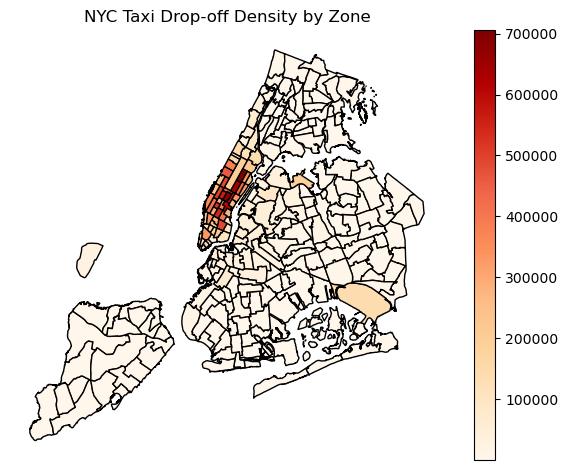

In [ ]:
# Visualize Zone Dropoff Heatmap on Map
zone_shapefile = "data/taxi/taxi_zones/taxi_zones.shp"  # Adjust path as needed
if os.path.exists(zone_shapefile):
    zones_gdf = gpd.read_file(zone_shapefile)
    zones_gdf["LocationID"] = zones_gdf["LocationID"].astype(int)
    zones_gdf = zones_gdf.set_index("LocationID").join(zone_total.rename("dropoff_count"))
    zones_gdf = zones_gdf.reset_index()
    plt.figure(figsize=(12,8))
    zones_gdf.plot(column='dropoff_count', cmap='OrRd', legend=True, edgecolor='black')
    plt.title("NYC Taxi Drop-off Density by Zone")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Shapefile for TLC zones not found. Please download and place at data/taxi/taxi_zones.shp")